In [1]:
import torch
from utils import LQR_2D_true_solution, out_put, LQR_1D_true_solution, l_2_compute_1D_Q, l_2_compute_1D_V, true_V_eval_2D, LQR_1D_PhiBE_true_solution_1st_order, LQR_1D_PhiBE_true_solution_2nd_order, LQR_1D_BE_true_solution
from bases import bases_poly, d_bases_poly, sec_bases_poly, bases_2d, bases_poly_simp, d_bases_poly_simp, sec_bases_poly_simp, bases_2d_simp, bases_poly_2D, bases_poly_2D_s_a, d_bases_poly_2D, bases_poly_2D_simp, d_bases_poly_2D_simp, sec_d_bases_poly_2D, sec_d_bases_poly_2D_simp
from main_phibe import phibe_finder_1D_LQR, phibe_finder_2D_LQR
from main_RL import RL_finder_1D_LQR, RL_finder_2D_LQR
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

In [2]:
torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

In [3]:
def reward(s, a):
    return - Q * (s**2) - R * (a**2)

In [4]:
# stochastic

In [5]:
A = -1.0
B = 0.5
sig = 0.1
R = 1
Q = 1
S = 0
beta = 3
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q,}
true_b, True_V = LQR_1D_true_solution(A, B, Q, R, sig, beta)
print(true_b, True_V)

-0.09901951359278449 tensor([-0.0007,  0.0000, -0.1980])


In [6]:
print(True_V)

tensor([-0.0007,  0.0000, -0.1980])


In [7]:
b_init = 0.5
c_init = 0.5
Q_init = 0.5 * torch.tensor([1., 1., 1., 1.]).to(device)

In [8]:
num_traj = 30

In [9]:
V_exact_dist_total_1st = torch.zeros(num_traj, 6)
V_exact_dist_total_2nd = torch.zeros(num_traj, 6)
V_exact_dist_total_RL = torch.zeros(num_traj, 6)

In [10]:
bd_low_s = -1.
bd_upper_s = 1.
bd_low_b = -1.
bd_upper_b = 1.
bd_low_c = -1.
bd_upper_c = 1.
bd_low_a = -1.
bd_upper_a = 1.
num_iter = 80
GD_num_iter = 80
I = 4
lr = 0.1
dt= 0.1
reward = reward
bases_V = bases_poly
d_bases_V = d_bases_poly
sec_d_bases_V = sec_bases_poly
bases_Q = bases_2d
true_V=True_V
simp_basis = False
deterministic = True

In [11]:
for traj_idx in range(num_traj):
    print(f'running experiment round {traj_idx}')
    V_exact_dist_final_1st = []
    V_exact_dist_final_2nd = []
    V_exact_dist_final_RL = []

    for batch_size in [5* int(1e2), int(1e3), int(1e4), int(1e5), int(1e6), 5 * int(1e6)]:
        b_init = 0.5
        c_init = 0.5
        Q_init = 0.5 * torch.tensor([1., 1., 1., 1., 1., 1.]).to(device)
        _, V_exact_dist_1, _ = phibe_finder_1D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis,
                                                                                     bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, int(batch_size / I), int(batch_size / I), I, lr, dt, 1, 
                                                                                     true_V, info_true)

        b_init = 0.5
        c_init = 0.5
        Q_init = 0.5 * torch.tensor([1., 1., 1., 1., 1., 1.]).to(device)
        _, V_exact_dist_2, _ = phibe_finder_1D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis,
                                                                                     bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, int(batch_size / I), int(batch_size / I), I, lr, dt, 2, 
                                                                                     true_V, info_true)

        b_init = 0.5
        c_init = 0.5
        Q_init = 0.5 * torch.tensor([1., 1., 1., 1., 1., 1.]).to(device)
        b_val_RL, V_exact_dist_RL = RL_finder_1D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, False, bases_Q, num_iter, int(batch_size / I), I, dt, true_V, info_true)

        V_exact_dist_final_1st.append(torch.tensor(V_exact_dist_1, dtype=torch.float64)[-10:].mean())
        V_exact_dist_final_2nd.append(torch.tensor(V_exact_dist_2, dtype=torch.float64)[-10:].mean())
        V_exact_dist_final_RL.append(torch.tensor(V_exact_dist_RL, dtype=torch.float64)[-10:].mean())


    V_exact_dist_total_2nd[traj_idx, :] = torch.tensor(V_exact_dist_final_2nd, dtype=torch.float64)
    V_exact_dist_total_1st[traj_idx, :] = torch.tensor(V_exact_dist_final_1st, dtype=torch.float64)
    V_exact_dist_total_RL[traj_idx, :] = torch.tensor(V_exact_dist_final_RL, dtype=torch.float64)

running experiment round 0


Running Optimal Phibe of order 1 using Galerkin:   0%|          | 0/80 [00:00<?, ?it/s]

Running Optimal BE PI: 100%|██████████| 80/80 [00:12<00:00,  6.40it/s]


running experiment round 1


Running Optimal BE PI: 100%|██████████| 80/80 [00:12<00:00,  6.32it/s]


running experiment round 2


Running Optimal BE PI: 100%|██████████| 80/80 [00:12<00:00,  6.37it/s]


running experiment round 3


Running Optimal BE PI: 100%|██████████| 80/80 [00:13<00:00,  5.88it/s]


running experiment round 4


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.18it/s]


running experiment round 5


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.42it/s]


running experiment round 6


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.43it/s]


running experiment round 7


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.26it/s]


running experiment round 8


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.25it/s]


running experiment round 9


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.40it/s]


running experiment round 10


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.39it/s]


running experiment round 11


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.28it/s]


running experiment round 12


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.36it/s]


running experiment round 13


Running Optimal BE PI: 100%|██████████| 80/80 [00:16<00:00,  4.99it/s]


running experiment round 14


Running Optimal BE PI: 100%|██████████| 80/80 [00:17<00:00,  4.54it/s]


running experiment round 15


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.28it/s]


running experiment round 16


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.59it/s]


running experiment round 17


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.48it/s]


running experiment round 18


Running Optimal BE PI: 100%|██████████| 80/80 [00:16<00:00,  4.86it/s]


running experiment round 19


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.50it/s]


running experiment round 20


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.45it/s]


running experiment round 21


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.23it/s]


running experiment round 22


Running Optimal BE PI: 100%|██████████| 80/80 [00:14<00:00,  5.35it/s]


running experiment round 23


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.00it/s]


running experiment round 24


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.29it/s]


running experiment round 25


Running Optimal BE PI: 100%|██████████| 80/80 [00:16<00:00,  4.88it/s]


running experiment round 26


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.17it/s]


running experiment round 27


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.00it/s]


running experiment round 28


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.17it/s]


running experiment round 29


Running Optimal BE PI: 100%|██████████| 80/80 [00:15<00:00,  5.11it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


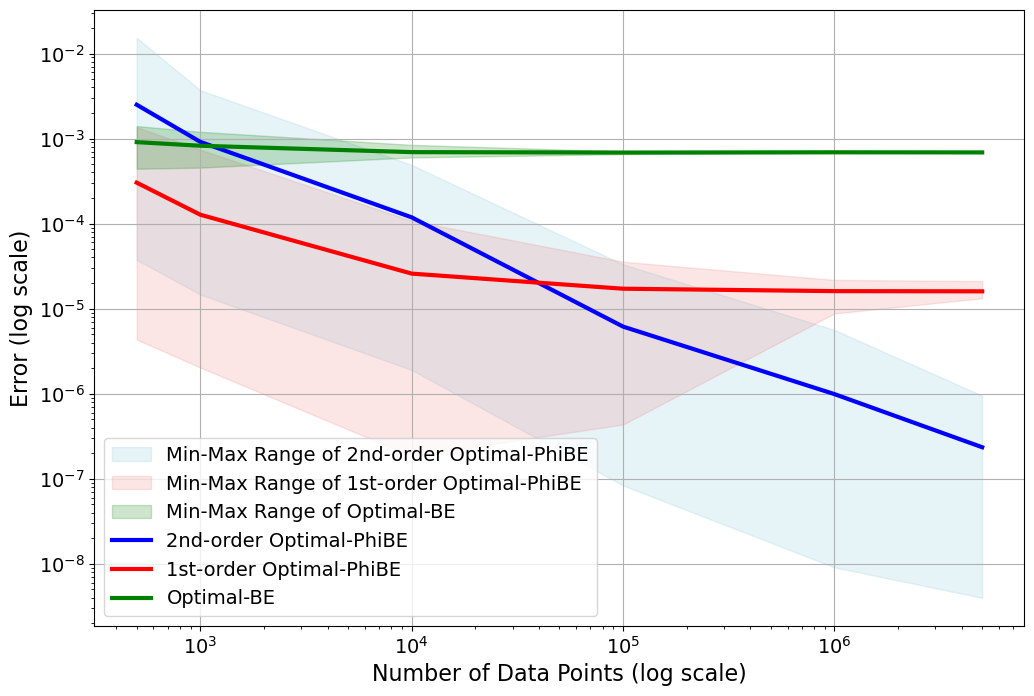

In [13]:
trajectories_RL = V_exact_dist_total_RL[:, :]
trajectories_2nd = V_exact_dist_total_2nd[:, :]
trajectories_1st = V_exact_dist_total_1st[:, :]

trajectories_np_RL = trajectories_RL.numpy()
trajectories_np_2nd = trajectories_2nd.numpy()
trajectories_np_1st = trajectories_1st.numpy()

x_values = [500, 1000, 10000, 100000, 1000000, 5 * 1e6]

min_trajectory_RL = trajectories_np_RL.min(axis=0)
max_trajectory_RL = trajectories_np_RL.max(axis=0)
mean_trajectory_RL = trajectories_np_RL.mean(axis=0)

min_trajectory_1st = trajectories_np_1st.min(axis=0)
max_trajectory_1st = trajectories_np_1st.max(axis=0)
mean_trajectory_1st = trajectories_np_1st.mean(axis=0)

min_trajectory_2nd = trajectories_np_2nd.min(axis=0)
max_trajectory_2nd = trajectories_np_2nd.max(axis=0)
mean_trajectory_2nd = trajectories_np_2nd.mean(axis=0)

plt.figure(figsize=(12, 8))

plt.fill_between(x_values, min_trajectory_2nd, max_trajectory_2nd, color='lightblue', alpha=0.3, label='Min-Max Range of 2nd-order Optimal-PhiBE')
plt.fill_between(x_values, min_trajectory_1st, max_trajectory_1st, color='lightcoral', alpha=0.2, label='Min-Max Range of 1st-order Optimal-PhiBE')
plt.fill_between(x_values, min_trajectory_RL, max_trajectory_RL, color='green', alpha=0.2, label='Min-Max Range of Optimal-BE')

plt.loglog(x_values, mean_trajectory_2nd, color='blue', linewidth=3, label='2nd-order Optimal-PhiBE')
plt.loglog(x_values, mean_trajectory_1st, color='red', linewidth=3, label='1st-order Optimal-PhiBE')
plt.loglog(x_values, mean_trajectory_RL, color='green', linewidth=3, label='Optimal-BE')

plt.xlabel('Number of Data Points (log scale)', fontsize=16)
plt.ylabel('Error (log scale)', fontsize=16)

plt.legend(fontsize=14)

plt.grid(True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("LQR/bs/bs.eps", format='eps')
plt.show()